In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings("ignore")

# 1. Load and Clean
df = pd.read_csv('twitter_stock.csv', parse_dates=['Date'])
# For demonstration, we assume 'df' exists with: Date, Open, High, Low, Volume, Adj Close

def preprocess_data(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df['Target'] = df['Adj Close'].shift(-1)
    # Fill missing business days and interpolate zeros/NaNs
    df = df.asfreq('B')
    df.replace(0, np.nan, inplace=True)
    df = df.interpolate(method='time').ffill().bfill()
    return df

target = 'Target'
df = preprocess_data(df)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

def get_metrics(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    r2 = r2_score(true, pred)

    true_diff = np.sign(np.array(true)[1:] - np.array(true)[:-1])
    pred_diff = np.sign(np.array(pred)[1:] - np.array(pred)[:-1])
    directional_acc = np.mean(true_diff == pred_diff) * 100 if len(true_diff) > 0 else np.nan
    print(f"[{name}] RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}, Directional Accuracy: {directional_acc:.2f}%")
    return [rmse, mape, r2, directional_acc]

print(f"Pipeline ready. Train: {len(train)}, Test: {len(test)}")

Pipeline ready. Train: 2111, Test: 235


In [ ]:
def get_features(history_df, model=None):
    """Calculates features for the most recent point in the provided history."""
    recent = history_df.tail(60).copy()

    std20 = recent['Adj Close'].rolling(20).std().iloc[-1]
    
    # Returns
    ret_1 = recent['Adj Close'].pct_change(1).iloc[-1]
    ret_3 = recent['Adj Close'].pct_change(3).iloc[-1]
    ret_5 = recent['Adj Close'].pct_change(5).iloc[-1]
    ret_10 = recent['Adj Close'].pct_change(10).iloc[-1]
    
    # Volatility
    vol_5 = recent['Adj Close'].rolling(5).std().iloc[-1]
    vol_10 = recent['Adj Close'].rolling(10).std().iloc[-1]
    vol_20 = recent['Adj Close'].rolling(20).std().iloc[-1]
    
    # ATR (Average True Range)
    high_low = recent['High'] - recent['Low']
    high_close = np.abs(recent['High'] - recent['Adj Close'].shift())
    low_close = np.abs(recent['Low'] - recent['Adj Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr14 = true_range.rolling(14).mean().iloc[-1]
    
    # RSI
    delta = recent['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean().iloc[-1]
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean().iloc[-1]
    rsi = 100 - (100 / (1 + (gain/loss))) if loss != 0 else 50
    
    # Moving Averages
    ma10 = recent['Adj Close'].rolling(10).mean().iloc[-1]
    ma50 = recent['Adj Close'].rolling(50).mean().iloc[-1]
    
    # MACD
    ema12 = recent['Adj Close'].ewm(span=12, adjust=False).mean().iloc[-1]
    ema26 = recent['Adj Close'].ewm(span=26, adjust=False).mean().iloc[-1]
    macd = ema12 - ema26

    if (model == 'lr') | (model == 'rf'):
        return np.array([
            recent['Open'].iloc[-1],
            recent['High'].iloc[-1],
            recent['Low'].iloc[-1],
            recent['Volume'].iloc[-1],
            ma10,
            ma50,
            macd,
            ema12,
            ema26,
            rsi,
            std20
        ]).reshape(1, -1)
    
    # ADX (Average Directional Index)
    plus_dm = recent['High'].diff()
    minus_dm = -recent['Low'].diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm < 0] = 0
    tr14 = true_range.rolling(14).sum().iloc[-1]
    plus_di = 100 * (plus_dm.rolling(14).sum().iloc[-1] / tr14)
    minus_di = 100 * (minus_dm.rolling(14).sum().iloc[-1] / tr14)
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    adx14 = dx
    
    # Price to MA ratios
    close_ma10_ratio = recent['Adj Close'].iloc[-1] / ma10
    close_ma50_ratio = recent['Adj Close'].iloc[-1] / ma50
    
    # Volume features
    vol_change = recent['Volume'].pct_change(1).iloc[-1]
    obv = (np.sign(recent['Adj Close'].diff()) * recent['Volume']).cumsum().iloc[-1]
    
    # MFI (Money Flow Index)
    typical_price = (recent['High'] + recent['Low'] + recent['Adj Close']) / 3
    money_flow = typical_price * recent['Volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0).rolling(14).sum().iloc[-1]
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0).rolling(14).sum().iloc[-1]
    mfi_ratio = positive_flow / negative_flow
    mfi = 100 - (100 / (1 + mfi_ratio))
    
    # Lagged signals
    ret_lag_1 = recent['Adj Close'].pct_change(1).shift(1).iloc[-1]
    ret_lag_2 = recent['Adj Close'].pct_change(1).shift(2).iloc[-1]
    ret_lag_3 = recent['Adj Close'].pct_change(1).shift(3).iloc[-1]
    rsi_lag_1 = (100 - (100 / (1 + ((delta.where(delta > 0, 0)).rolling(14).mean() / (-delta.where(delta < 0, 0)).rolling(14).mean())))).shift(1).iloc[-1]
    rsi_lag_2 = (100 - (100 / (1 + ((delta.where(delta > 0, 0)).rolling(14).mean() / (-delta.where(delta < 0, 0)).rolling(14).mean())))).shift(2).iloc[-1]
    
    return np.array([
        recent['Open'].iloc[-1],
        recent['High'].iloc[-1],
        recent['Low'].iloc[-1],
        recent['Volume'].iloc[-1],
        ret_1, ret_3, ret_5, ret_10,
        vol_5, vol_10, vol_20, atr14,
        rsi, macd, adx14,
        close_ma10_ratio, close_ma50_ratio,
        vol_change, obv, mfi,
        ret_lag_1, ret_lag_2, ret_lag_3,
        rsi_lag_1, rsi_lag_2,
        ema12, ema26, ma10, ma50, std20
    ]).reshape(1, -1)

# Base features for initial training
def prepare_static_features(data_df, model=None):
    temp = data_df.copy()
    
    temp['STD20'] = temp['Adj Close'].rolling(20).std()

    # Returns
    temp['ret_1'] = temp['Adj Close'].pct_change(1)
    temp['ret_3'] = temp['Adj Close'].pct_change(3)
    temp['ret_5'] = temp['Adj Close'].pct_change(5)
    temp['ret_10'] = temp['Adj Close'].pct_change(10)
    
    # Volatility
    temp['vol_5'] = temp['Adj Close'].rolling(5).std()
    temp['vol_10'] = temp['Adj Close'].rolling(10).std()
    temp['vol_20'] = temp['Adj Close'].rolling(20).std()
    
    # ATR (Average True Range)
    high_low = temp['High'] - temp['Low']
    high_close = np.abs(temp['High'] - temp['Adj Close'].shift())
    low_close = np.abs(temp['Low'] - temp['Adj Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    temp['ATR14'] = true_range.rolling(14).mean()
    
    # RSI
    delta = temp['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    temp['RSI'] = 100 - (100 / (1 + (gain/loss)))
    
    # Moving Averages
    temp['MA10'] = temp['Adj Close'].rolling(10).mean()
    temp['MA50'] = temp['Adj Close'].rolling(50).mean()
    
    # MACD
    temp['EMA12'] = temp['Adj Close'].ewm(span=12, adjust=False).mean()
    temp['EMA26'] = temp['Adj Close'].ewm(span=26, adjust=False).mean()
    temp['MACD'] = temp['EMA12'] - temp['EMA26']
    
    # ADX (Average Directional Index)
    plus_dm = temp['High'].diff()
    minus_dm = -temp['Low'].diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm < 0] = 0
    tr14 = true_range.rolling(14).sum()
    plus_di = 100 * (plus_dm.rolling(14).sum() / tr14)
    minus_di = 100 * (minus_dm.rolling(14).sum() / tr14)
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    temp['ADX14'] = dx.rolling(14).mean()
    
    # Price to MA ratios
    temp['close_ma10_ratio'] = temp['Adj Close'] / temp['MA10']
    temp['close_ma50_ratio'] = temp['Adj Close'] / temp['MA50']
    
    # Volume features
    temp['vol_change'] = temp['Volume'].pct_change(1)
    temp['OBV'] = (np.sign(temp['Adj Close'].diff()) * temp['Volume']).cumsum()
    
    # MFI (Money Flow Index)
    typical_price = (temp['High'] + temp['Low'] + temp['Adj Close']) / 3
    money_flow = typical_price * temp['Volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0).rolling(14).sum()
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0).rolling(14).sum()
    mfi_ratio = positive_flow / negative_flow
    temp['MFI'] = 100 - (100 / (1 + mfi_ratio))
    
    # Lagged signals
    temp['ret_lag_1'] = temp['ret_1'].shift(1)
    temp['ret_lag_2'] = temp['ret_1'].shift(2)
    temp['ret_lag_3'] = temp['ret_1'].shift(3)
    temp['RSI_lag_1'] = temp['RSI'].shift(1)
    temp['RSI_lag_2'] = temp['RSI'].shift(2)
    
    temp = temp.dropna()

    if (model == 'lr') | (model == 'rf'):
        features = [
            'Open', 'High', 'Low', 'Volume',
            'MA10', 'MA50', 'MACD', 'EMA12', 'EMA26', 'RSI', 'STD20'
        ]
    else:
        features = [
        'Open', 'High', 'Low', 'Volume',
        # Returns
        'ret_1', 'ret_3', 'ret_5', 'ret_10',
        
        # Volatility
        'vol_5', 'vol_10', 'vol_20', 'ATR14',
        
        # Trend & momentum
        'RSI', 'MACD', 'ADX14',
        'close_ma10_ratio', 'close_ma50_ratio',
        
        # Volume
        'vol_change', 'OBV', 'MFI',
        
        # Lagged signals
        'ret_lag_1', 'ret_lag_2', 'ret_lag_3',
        'RSI_lag_1', 'RSI_lag_2',

        'EMA12', 'EMA26', 'MA10', 'MA50',
        'STD20'
    ]
    
    return temp[features], temp[target]

In [3]:
import numpy as np
from sklearn.metrics import make_scorer

def directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # direction compared to previous true value
    true_dir = np.sign(y_true[1:] - y_true[:-1])
    pred_dir = np.sign(y_pred[1:] - y_true[:-1])

    return np.mean(true_dir == pred_dir)

da_scorer = make_scorer(directional_accuracy, greater_is_better=True)

[Linear Regression] RMSE: 2.13, MAPE: 3.38%, R2: 0.8438, Directional Accuracy: 48.29%


Text(0.5, 1.0, 'Linear Regression')

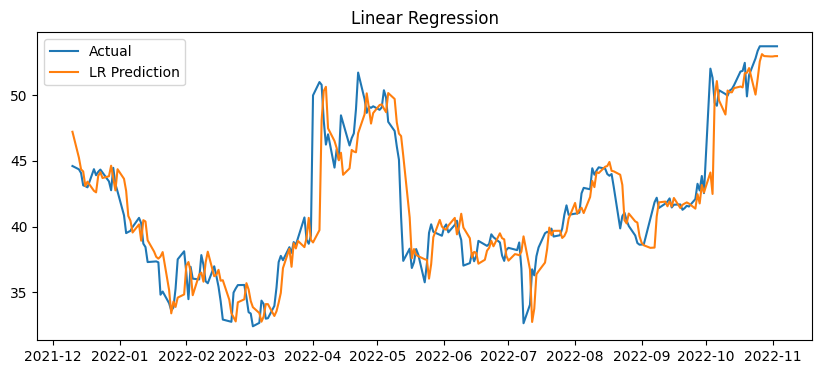

In [4]:
from sklearn.linear_model import LinearRegression

X_static_lr, y_static_lr = prepare_static_features(train, model='lr')

lr_model = LinearRegression().fit(X_static_lr, y_static_lr)
lr_preds = []
history = train.copy()

for i in range(len(test)):
    X_curr = get_features(history, model='lr')
    lr_preds.append(lr_model.predict(X_curr)[0])
    history = pd.concat([history, test.iloc[[i]]])

lr_res = get_metrics(test[target], lr_preds, "Linear Regression")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, lr_preds, label='LR Prediction')
plt.legend()
plt.title("Linear Regression")

Searching for optimized Random Forest parameters using RandomizedSearchCV...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best RF Parameters Found: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'squared_error', 'bootstrap': True}
Running Recursive Walk-Forward for Random Forest...

Optimized Random Forest Metrics:
[Random Forest (Optimized)] RMSE: 2.49, MAPE: 4.33%, R2: 0.7858, Directional Accuracy: 44.02%


Text(0.5, 1.0, 'Random Forest')

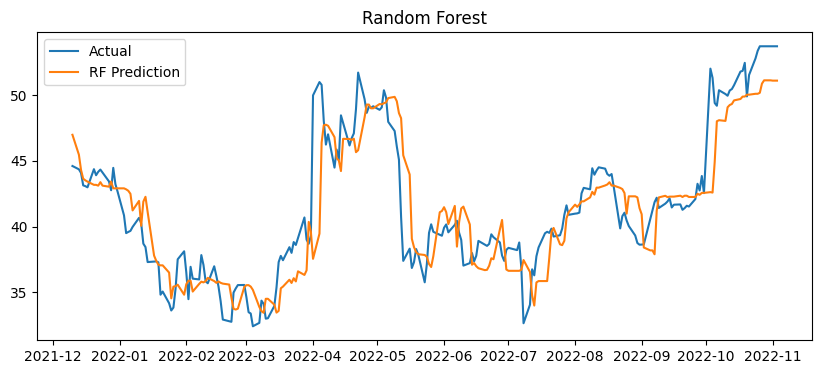

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

X_static_rf, y_static_rf = prepare_static_features(train, model='rf')

# 1. DEFINE PARAMETER GRID
# Expanded grid for comprehensive random search
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 700, 1000],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 3, 4, 5, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error']
}

# 2. TIME SERIES CROSS-VALIDATION
# Ensuring chronological validation to prevent data leakage
tscv = TimeSeriesSplit(n_splits=5)
rf_base = RandomForestRegressor(random_state=42)

print("Searching for optimized Random Forest parameters using RandomizedSearchCV...")
rf_random_search = RandomizedSearchCV(
    estimator=rf_base, 
    param_distributions=rf_param_grid,
    n_iter=100,
    cv=tscv, 
    scoring=da_scorer, 
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 3. INITIAL TRAINING
# Using the static features (OHLCV + Technical Indicators) from the training set
rf_random_search.fit(X_static_rf, y_static_rf)
best_rf_model = rf_random_search.best_estimator_
print(f"Best RF Parameters Found: {rf_random_search.best_params_}")

# 4. RECURSIVE WALK-FORWARD PREDICTION
rf_preds = []
history = train.copy()

print("Running Recursive Walk-Forward for Random Forest...")
for i in range(len(test)):
    # Calculate features for 'today' using only past data
    X_curr = get_features(history, model='rf')
    
    # Predict tomorrow's Adj Close
    rf_preds.append(best_rf_model.predict(X_curr)[0])
    
    # Update history with the actual row from the test set
    actual_row = test.iloc[[i]]
    history = pd.concat([history, actual_row])

# 5. EVALUATION
print("\nOptimized Random Forest Metrics:")
rf_res = get_metrics(test[target], rf_preds, "Random Forest (Optimized)")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, rf_preds, label='RF Prediction')
plt.legend()
plt.title("Random Forest")


In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

X_static_xgb, y_static_xgb = prepare_static_features(train)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 700, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.07, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.15, 0.2],
    'min_child_weight': [1, 2, 3, 4, 5],
    'reg_alpha': [0, 0.001, 0.01, 0.05, 0.1],
    'reg_lambda': [0.5, 1, 1.5, 2, 3]
}

tscv = TimeSeriesSplit(n_splits=5)
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

print("Searching for optimized XGBoost parameters using RandomizedSearchCV...")
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base, 
    param_distributions=param_grid,
    n_iter=500,  # Only try 1000 random combinations
    cv=tscv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 3. INITIAL TRAINING
# Fit the search using the static features prepared from the 90% training data
xgb_random_search.fit(X_static_xgb, y_static_xgb)
best_xgb_model = xgb_random_search.best_estimator_
print(f"Best Parameters Found: {xgb_random_search.best_params_}")

# 4. RECURSIVE WALK-FORWARD PREDICTION
# This loop recalculates features every day using only past information
xgb_preds = []
history = train.copy()

print("Running Recursive Walk-Forward for XGBoost...")
for i in range(len(test)):
    # Calculate features for 'today' based on history
    X_curr = get_features(history)
    
    # Predict tomorrow's price
    xgb_preds.append(best_xgb_model.predict(X_curr)[0])
    
    # Update history with the actual row from the test set for next day's feature calculation
    actual_row = test.iloc[[i]]
    history = pd.concat([history, actual_row])

xgb_res = get_metrics(test[target], xgb_preds, "XGBoost")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, xgb_preds, label='XGBoost Prediction')
plt.legend()
plt.title("XGBoost")


Searching for optimized XGBoost parameters using RandomizedSearchCV...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Parameters Found: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.001, 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Running Recursive Walk-Forward for XGBoost...


ValueError: Feature shape mismatch, expected: 30, got 31

[ARIMA] RMSE: 1.46, MAPE: 2.17%, R2: 0.9263, Directional Accuracy: 52.99%


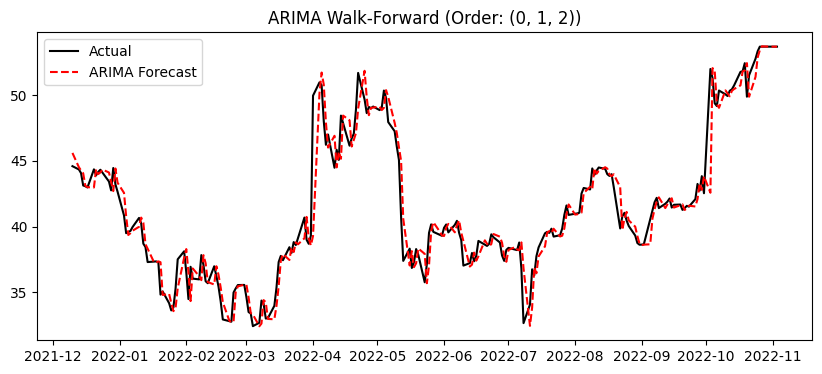

In [ ]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Find best parameters
arima_search = pm.auto_arima(train[target], seasonal=False, stepwise=True, suppress_warnings=True)
best_order = arima_search.order

arima_history = list(train[target])
arima_preds = []

for t in range(len(test)):
    model_fit = ARIMA(arima_history, order=best_order).fit()
    arima_preds.append(model_fit.forecast()[0])
    arima_history.append(test[target].iloc[t])

arima_res = get_metrics(test[target], arima_preds, "ARIMA")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual', color='black')
plt.plot(test.index, arima_preds, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f"ARIMA Walk-Forward (Order: {best_order})")
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
import random

# 1. SCALE DATA
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = lstm_scaler.fit_transform(train[[target]])

# 2. SEQUENCE PREPARATION
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 60
X_train_lstm, y_train_lstm = create_sequences(scaled_train, seq_len)

# 3. OPTIMIZATION SEARCH (Random Search)
# Extended param grid for more comprehensive search
def build_lstm(units, dropout, lr, optimizer, batch_norm, dense_units):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(seq_len, 1)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(LSTM(int(units/2), return_sequences=False))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    if dense_units > 0:
        model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    if optimizer == 'adam':
        opt = Adam(learning_rate=lr)
    else:
        opt = RMSprop(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model

param_grid = {
    'units': [32, 48, 64, 96, 128, 160, 192],
    'dropout': [0.1, 0.15, 0.2, 0.25, 0.3],
    'lr': [0.0005, 0.001, 0.002, 0.005, 0.01],
    'optimizer': ['adam', 'rmsprop'],
    'batch_norm': [True, False],
    'dense_units': [0, 8, 16, 32, 64]
}
best_val_loss = float('inf')
best_lstm_model = None

print("Searching for optimized LSTM architecture...")
n_searches = 30  # Increased number of random searches
for _ in range(n_searches):
    u = random.choice(param_grid['units'])
    d = random.choice(param_grid['dropout'])
    l = random.choice(param_grid['lr'])
    o = random.choice(param_grid['optimizer'])
    b = random.choice(param_grid['batch_norm'])
    du = random.choice(param_grid['dense_units'])
    m = build_lstm(u, d, l, o, b, du)
    history = m.fit(X_train_lstm, y_train_lstm, validation_split=0.1, epochs=7, batch_size=32, verbose=0)
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lstm_model = m
        print(f"Found better model -> Units: {u}, Dropout: {d}, LR: {l}, Optimizer: {o}, BatchNorm: {b}, DenseUnits: {du}")

# 4. FINAL TRAINING
print("Finalizing training on full training set...")
best_lstm_model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=32, verbose=0)

# 5. RECURSIVE WALK-FORWARD PREDICTION
# This part ensures NO data leakage by updating the batch with actuals day-by-day
lstm_preds = []
current_batch = scaled_train[-seq_len:].reshape(1, seq_len, 1)

print("Running Recursive Walk-Forward for LSTM...")
for i in range(len(test)):
    # Predict next day based on current window
    pred_scaled = best_lstm_model.predict(current_batch, verbose=0)
    lstm_preds.append(lstm_scaler.inverse_transform(pred_scaled)[0,0])
    
    # Take actual price from test set, scale it, and slide the window
    actual_val = test[target].iloc[i]
    actual_scaled = lstm_scaler.transform([[actual_val]]).reshape(1, 1, 1)
    
    # Update current_batch: [Oldest 59 days] + [Newest actual day]
    current_batch = np.append(current_batch[:, 1:, :], actual_scaled, axis=1)

# 6. METRICS
print("\nOptimized LSTM Metrics:")
lstm_res = get_metrics(test[target], lstm_preds, "LSTM (Optimized)")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target].values, label='Actual Adj Close')
plt.plot(test.index, lstm_preds, label='LSTM Predicted', color='orange')
plt.title("LSTM Optimized: Actual vs Predicted")
plt.legend()
plt.show()

Searching for optimized LSTM architecture...
Found better model -> Units: 96, Dropout: 0.3, LR: 0.005, Optimizer: rmsprop, BatchNorm: False, DenseUnits: 0
Found better model -> Units: 64, Dropout: 0.25, LR: 0.01, Optimizer: rmsprop, BatchNorm: False, DenseUnits: 16


KeyboardInterrupt: 

Importing plotly failed. Interactive plots will not work.
12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing


Running Recursive Walk-Forward for Prophet...


12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing
12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing
12:32:30 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing
12:32:33 - cmdstanpy - INFO - Chain [1] start processing
12:32:33 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:36 - cmdstanpy - INFO - Chain [1] done processing
12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:32:39 - cmdstanpy - INFO - Chain [1] done processing
12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing
12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1] done processing
12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1]


Fixed Prophet (Recursive, No Look-Ahead) Metrics:
[Prophet_Fixed] RMSE: 2.21, MAPE: 3.79%, R2: 0.8321, Directional Accuracy: 51.28%


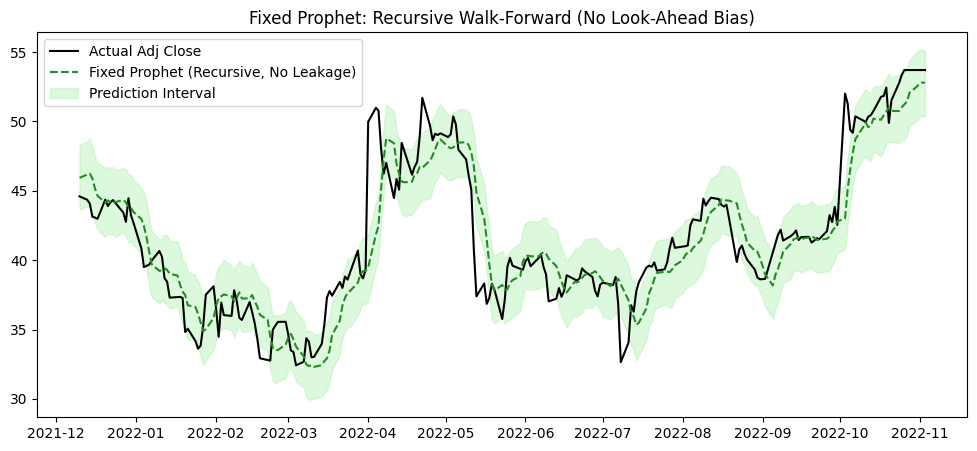

In [ ]:
from prophet import Prophet

# 1. Feature Engineering for Prophet
# We create lagged features that will be available at prediction time
prophet_prep = train.copy()
prophet_prep['Lagged_Volume'] = prophet_prep['Volume'].shift(1)
prophet_prep['MA5'] = prophet_prep[target].rolling(window=5).mean().shift(1)
prophet_prep = prophet_prep.dropna()

# Prepare Dataframe
prophet_df = prophet_prep.reset_index()[['Date', target, 'Lagged_Volume', 'MA5']].rename(
    columns={'Date': 'ds', target: 'y'}
)

# 2. Configure with Optimized Priors (Initial Model - will be retrained during walk-forward)
m = Prophet(
    changepoint_prior_scale=0.01,    # Allow slight trend flexibility
    seasonality_prior_scale=0.05,   # Strongly dampen seasonality to prevent 'ghost' cycles
    holidays_prior_scale=0.1,       # Account for market holidays
    seasonality_mode='multiplicative',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

# Add US Market Holidays
m.add_country_holidays(country_name='US')

# Add Lagged Regressors
m.add_regressor('Lagged_Volume')
m.add_regressor('MA5')

# 3. Initial Fit
m.fit(prophet_df)

# 4. RECURSIVE WALK-FORWARD PREDICTION (Fixed to prevent look-ahead bias)
# We must use only past data to predict each future point
prop_preds = []
prop_lower = []
prop_upper = []
prophet_history = train.copy()

print("Running Recursive Walk-Forward for Prophet...")
for i in range(len(test)):
    # Prepare training data with lagged features using only historical data
    temp_train = prophet_history.copy()
    temp_train['Lagged_Volume'] = temp_train['Volume'].shift(1)
    temp_train['MA5'] = temp_train[target].rolling(window=5).mean().shift(1)
    temp_train = temp_train.dropna()
    
    prophet_df_temp = temp_train.reset_index()[['Date', target, 'Lagged_Volume', 'MA5']].rename(
        columns={'Date': 'ds', target: 'y'}
    )
    
    # Retrain model on growing history (or reuse if too slow)
    if i == 0 or i % 10 == 0:  # Retrain every 10 steps to balance speed and accuracy
        m_temp = Prophet(
            changepoint_prior_scale=0.01,
            seasonality_prior_scale=0.05,
            holidays_prior_scale=0.1,
            seasonality_mode='multiplicative',
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True
        )
        m_temp.add_country_holidays(country_name='US')
        m_temp.add_regressor('Lagged_Volume')
        m_temp.add_regressor('MA5')
        m_temp.fit(prophet_df_temp)
    
    # Create future dataframe for next day only
    future_day = pd.DataFrame({'ds': [test.index[i]]})
    
    # Calculate regressors using ONLY historical data
    last_volume = prophet_history['Volume'].iloc[-1]
    last_ma5 = prophet_history[target].tail(5).mean()
    
    future_day['Lagged_Volume'] = last_volume
    future_day['MA5'] = last_ma5
    
    # Predict
    forecast_day = m_temp.predict(future_day)
    prop_preds.append(forecast_day['yhat'].values[0])
    prop_lower.append(forecast_day['yhat_lower'].values[0])
    prop_upper.append(forecast_day['yhat_upper'].values[0])
    
    # Update history with actual values
    prophet_history = pd.concat([prophet_history, test.iloc[[i]]])

prop_preds = np.array(prop_preds)

# 5. Evaluation
print("\nFixed Prophet (Recursive, No Look-Ahead) Metrics:")
prop_res = get_metrics(test[target].values, prop_preds, "Prophet_Fixed")

# 6. Visualization
# For uncertainty intervals, use the last trained model's forecast
future_all = m_temp.make_future_dataframe(periods=1, freq='B')
last_vol = prophet_history['Volume'].iloc[-1]
last_ma = prophet_history[target].tail(5).mean()
future_all['Lagged_Volume'] = last_vol
future_all['MA5'] = last_ma
forecast_sample = m_temp.predict(future_all)

plt.figure(figsize=(12, 5))
plt.plot(test.index, test[target].values, label='Actual Adj Close', color='black', linewidth=1.5)
plt.plot(test.index, prop_preds, label='Fixed Prophet (Recursive, No Leakage)', color='forestgreen', linestyle='--')
plt.fill_between(
    test.index, 
    np.array(prop_lower), 
    np.array(prop_upper), 
    color='lightgreen', alpha=0.3, label='Prediction Interval'
)
plt.title("Fixed Prophet: Recursive Walk-Forward (No Look-Ahead Bias)")
plt.legend()
plt.show()

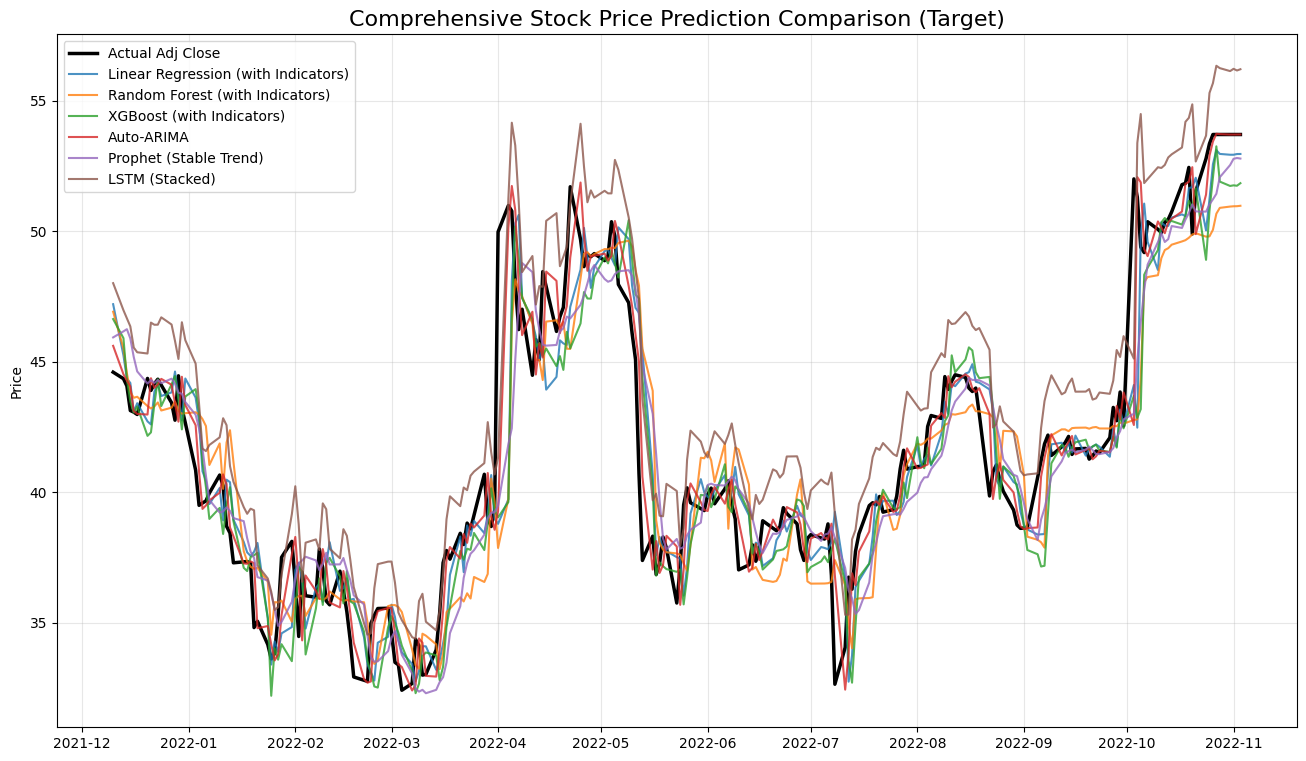

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(test.index, test[target], label='Actual Adj Close', color='black', linewidth=2.5)
plt.plot(test.index, lr_preds, label='Linear Regression (with Indicators)', alpha=0.8)
plt.plot(test.index, rf_preds, label='Random Forest (with Indicators)', alpha=0.8)
plt.plot(test.index, xgb_preds, label='XGBoost (with Indicators)', alpha=0.8)
plt.plot(test.index, arima_preds, label='Auto-ARIMA', alpha=0.8)
plt.plot(test.index, prop_preds, label='Prophet (Stable Trend)', alpha=0.8)
plt.plot(test.index, lstm_preds, label='LSTM (Stacked)', alpha=0.8)

plt.title(f'Comprehensive Stock Price Prediction Comparison ({target})', fontsize=16)
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

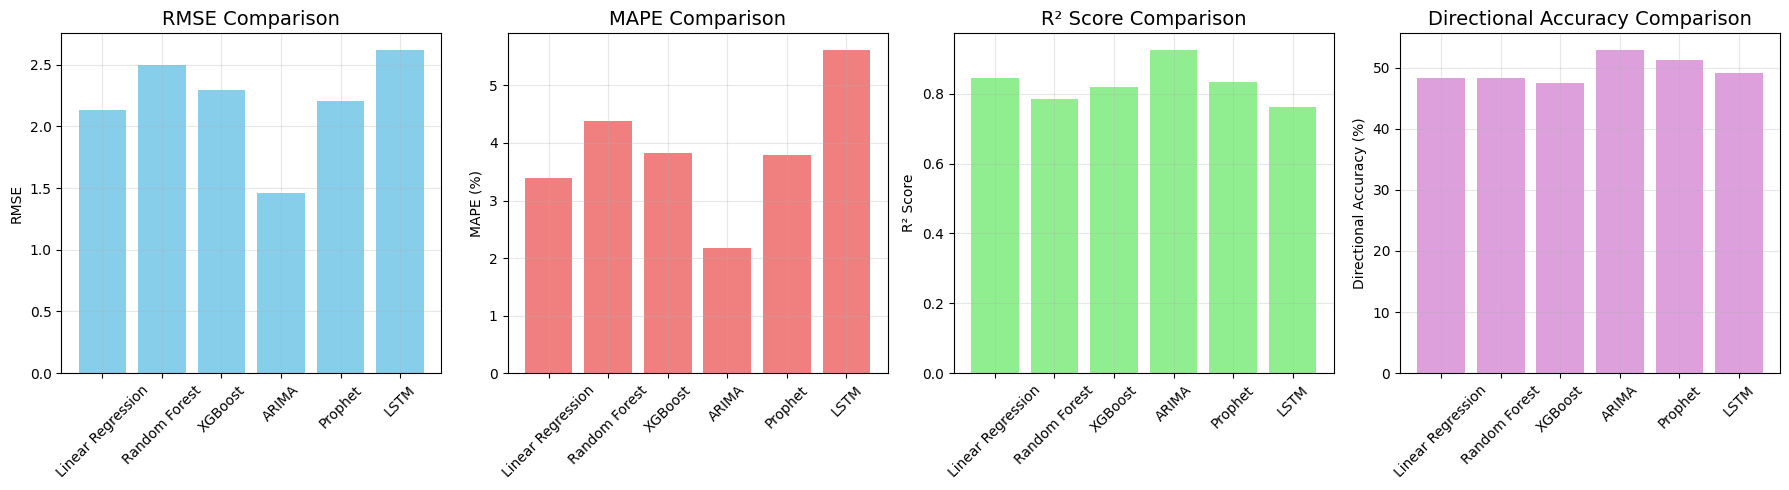

In [ ]:
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'ARIMA', 'Prophet', 'LSTM']
rmse_values = [lr_res[0], rf_res[0], xgb_res[0], arima_res[0], prop_res[0], lstm_res[0]]
mape_values = [lr_res[1], rf_res[1], xgb_res[1], arima_res[1], prop_res[1], lstm_res[1]]
r2_values = [lr_res[2], rf_res[2], xgb_res[2], arima_res[2], prop_res[2], lstm_res[2]]
da_values = [lr_res[3], rf_res[3], xgb_res[3], arima_res[3], prop_res[3], lstm_res[3]]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].bar(models, rmse_values, color='skyblue')
axes[0].set_title('RMSE Comparison', fontsize=14)
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].bar(models, mape_values, color='lightcoral')
axes[1].set_title('MAPE Comparison', fontsize=14)
axes[1].set_ylabel('MAPE (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

axes[2].bar(models, r2_values, color='lightgreen')
axes[2].set_title('R² Score Comparison', fontsize=14)
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

axes[3].bar(models, da_values, color='plum')
axes[3].set_title('Directional Accuracy Comparison', fontsize=14)
axes[3].set_ylabel('Directional Accuracy (%)')
axes[3].tick_params(axis='x', rotation=45)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()